# Скачивание и предобработка данных с Kaggle

In [1]:
# Установка библиотеки kaggle
!pip install kaggle
# Скачиваем датасет
!kaggle datasets download -d thedownhill/art-images-drawings-painting-sculpture-engraving
# Вручную переносим данные в рабочую папку и распаковываем файл dataset.zip

Traceback (most recent call last):
  File "/home/ishvlad/miniconda2/envs/py27/bin/kaggle", line 7, in <module>
    from kaggle.cli import main
  File "/home/ishvlad/miniconda2/envs/py27/lib/python2.7/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/home/ishvlad/miniconda2/envs/py27/lib/python2.7/site-packages/kaggle/api/kaggle_api_extended.py", line 113, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /home/ishvlad/.kaggle. Or use the environment method.


In [2]:
from glob import glob
import numpy as np
import os
import pandas as pd
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torchvision
from IPython import display
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline



In [4]:
training_folder = 'art-images-drawings-painting-sculpture-engraving/dataset_updated/training_set/'
validation_folder = 'art-images-drawings-painting-sculpture-engraving/dataset_updated/validation_set/'

# Эскиз, гравюра, икона, картина, скульптура
categories = ['drawings', 'engraving', 'iconography', 'painting', 'sculpture']
cat_to_cls = {
    'drawings': 0,
    'engraving': 1,
    'iconography': 2,
    'painting': 3,
    'sculpture': 4
}

# Наши изображения имеют разный размер, поэтому стоит привести их к одинаковому
image_h, image_w, channels = 224, 224, 3

n_classes = len(categories)

In [5]:
def load_image(img_path, need_resize=True):
    img = imread(img_path)
    if need_resize:
        img = resize(img, (image_w, image_h, channels), mode='reflect') 
        img = np.swapaxes(img, 0, 2)
    return img

(320, 224, 3)
(320, 372, 3)
(320, 427, 3)
(320, 290, 3)
(320, 374, 3)


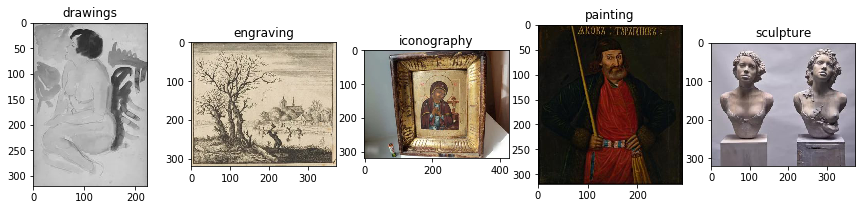

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=n_classes, figsize=(15, 3))


for i, cat in enumerate(categories):
    category_path = os.path.join(training_folder, cat)
    img_name = os.listdir(category_path)[4]
    img = load_image(os.path.join(category_path, img_name), need_resize=False)
    print(img.shape)
    axes[i].imshow(img, resample=True)
    axes[i].set_title(cat, fontsize=12)

plt.show()

In [7]:
def load_images_of_category(category):
    print('Загрузка изображений из категории %s' % category)
    
    # one-hot encoding
    #     label = np.zeros(n_classes)
    #     label[cat_to_cls[category]] = 1
    
    label = cat_to_cls[category]

    
    # тренировочные изображения
    category_folder = os.path.join(training_folder, category, '*.jpeg')
    all_images = glob(category_folder)
    train_imgs = [load_image(img) for img in all_images]
    train_labels = [label for _ in range(len(train_imgs))]
    
    # валидационные изображения
    category_folder = os.path.join(validation_folder, category, '*.jpeg')
    all_images = glob(category_folder)
    val_imgs = [load_image(img) for img in all_images]
    val_labels = [label for _ in range(len(val_imgs))]
    
    return train_imgs, train_labels, val_imgs, val_labels

In [8]:
X_train, y_train, X_val, y_val = [], [], [], []

for cat in categories:
    train_imgs, train_labels, val_imgs, val_labels = load_images_of_category(cat)
    X_train.extend(train_imgs)
    y_train.extend(train_labels)
    X_val.extend(val_imgs)
    y_val.extend(val_labels)
    
X_train, y_train, X_val, y_val = np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val)

Загрузка изображений из категории drawings
Загрузка изображений из категории engraving
Загрузка изображений из категории iconography
Загрузка изображений из категории painting
Загрузка изображений из категории sculpture


In [9]:
def iterate_minibatches(inputs, targets, batchsize):
    assert len(inputs) == len(targets)
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        excerpt = indices[start_idx:start_idx + batchsize]
        yield inputs[excerpt], targets[excerpt]

## Параметры обучения

In [10]:
batch_size = 64
n_epochs = 20
lr = 1e-3

In [11]:
def get_accuracy(net, x, y):
    net = net.eval()
    
    correct = 0
    for x_batch, y_batch in iterate_minibatches(x, y, batchsize=batch_size):
        x_batch = torch.FloatTensor(x_batch)
        data = Variable(x_batch).cuda()
        output = net(data)
        correct += (output.cpu().detach().numpy().argmax(1) == y_batch).sum()
        
    accuracy = 1.0 * correct / len(y)
    
    return accuracy

## Функция обучения нейросети

In [12]:
def train(net, opt, X_train, y_train, X_val, y_val, n_epochs, lr, batch_size):
    losses, accuracies = [], []
    
    for epoch in tqdm(range(n_epochs)):
        for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=batch_size):
            net = net.train()
            x_batch, y_batch = torch.FloatTensor(x_batch), torch.LongTensor(y_batch)
            data, target = Variable(x_batch).cuda(), Variable(y_batch).cuda()
            opt.zero_grad()
            output = net(data)
            loss = F.nll_loss(output, target, reduction='sum')
            losses.append(loss.item())
            loss.backward()
            opt.step()

        accuracy = get_accuracy(net, X_val, y_val)
#         print('accuracy after epoch %s is %.4f' % (epoch, accuracy))
        accuracies.append(accuracy)

#         display.clear_output(wait=True)
#         display.display(plt.gcf())

    plt.plot(losses, 'b')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    
    return accuracies

## Модель 1: полносвязная нейросеть

100%|██████████| 20/20 [00:04<00:00,  4.64it/s]

Max accuracy: 0.6707


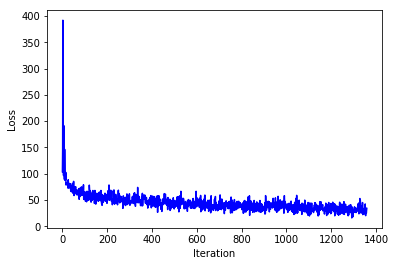

In [44]:
class FC(nn.Module):
    def __init__(self):
        super(FC, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(channels * image_h * image_w, 512), #196608 input vecotr
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, n_classes)
        )
        
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        x = x.view(batch_size, -1)
        
        x = self.fc(x)
        
        return F.log_softmax(x, dim=1)

net = FC().cuda()
opt = optim.Adam(net.parameters(), lr)

accuracies = train(net, opt, X_train, y_train, X_val, y_val, n_epochs, lr, batch_size)

print('Max accuracy: %.4f' % np.max(accuracies))

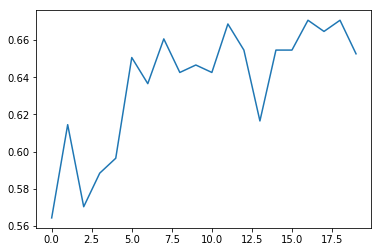

In [45]:
plt.plot(accuracies)

In [46]:
results = {'Fully connected': np.max(accuracies)}

## Модель 2: свёрточная нейросеть с двумя слоями

100%|██████████| 20/20 [00:08<00:00,  2.45it/s]

Max accuracy: 0.6928


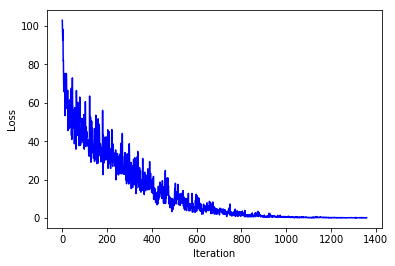

In [47]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, 10, kernel_size=5),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.ReLU(),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(62720, n_classes)
        )
        
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = self.conv(x)
        
        x = x.view(batch_size, -1)
        
        x = self.fc(x)
        
        return F.log_softmax(x, dim=1)

net = ConvNet().cuda()
opt = optim.Adam(net.parameters(), lr)

accuracies = train(net, opt, X_train, y_train, X_val, y_val, n_epochs, lr, batch_size)

print('Max accuracy: %.4f' % np.max(accuracies))

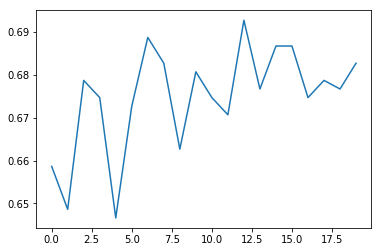

In [48]:
plt.plot(accuracies)

In [49]:
results['ConvNet'] = np.max(accuracies)

## Модель 3: свёрточная нейросеть + Max Pooling

100%|██████████| 20/20 [00:07<00:00,  2.83it/s]

Max accuracy: 0.7349


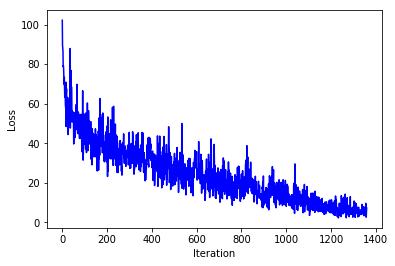

In [50]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, 32, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(32, 48, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(8112, n_classes)
        )
        
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = self.conv(x)
#         print(x.shape)
        x = x.view(batch_size, -1)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

net = ConvNet().cuda()
opt = optim.Adam(net.parameters(), 1e-3)

accuracies = train(net, opt, X_train, y_train, X_val, y_val, n_epochs, lr, batch_size)

print('Max accuracy: %.4f' % np.max(accuracies))

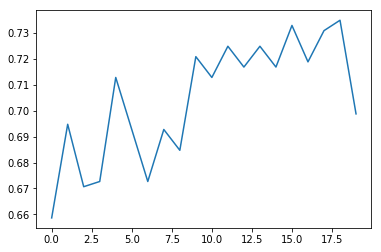

In [51]:
plt.plot(accuracies)

In [52]:
results['ConvNet + MaxPool'] = np.max(accuracies)

## Модель 4: свёрточная нейросеть + Max Pooling + Batch Normalization

100%|██████████| 20/20 [00:10<00:00,  1.87it/s]

Max accuracy: 0.7410


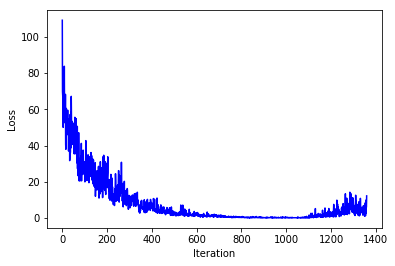

In [53]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv = nn.Sequential(
            nn.BatchNorm2d(channels),
            nn.Conv2d(channels, 32, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 48, kernel_size=5),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.BatchNorm2d(48),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(8112, n_classes) # 20 * 13 * 13
        )
        
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = self.conv(x)
#         print(x.shape)
        x = x.view(batch_size, -1)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

net = ConvNet().cuda()
opt = optim.Adam(net.parameters(), lr)

accuracies = train(net, opt, X_train, y_train, X_val, y_val, n_epochs, lr, batch_size)

print('Max accuracy: %.4f' % np.max(accuracies))

In [92]:


results = {
    'Fully connected': 0.6686746987951807,
    'ConvNet': 0.6867469879518072,
    'ConvNet + MaxPool': 0.714859437751004,
    'ConvNet + MaxPool + BN': 0.751004016064257,
    'ConvNet + MaxPool + BN + Aug': 0.757028
}

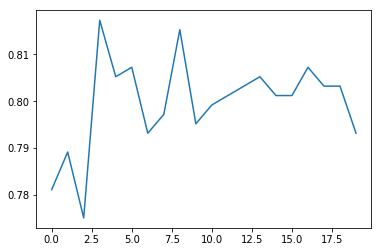

In [93]:
plt.plot(accuracies)
# X_train = np.array([resize(x, (3, 224, 224)) for x in X_train])
# X_val = np.array([resize(x, (3, 224, 224)) for x in X_val])

In [14]:
results['ConvNet + MaxPool + BN'] = np.max(accuracies)



import random
import torch
import numpy as np
i = 0
np.random.seed(i)
random.seed(i)


In [16]:
pd.DataFrame.sort_values(pd.DataFrame(pd.Series(results), columns=['Accuracy']), 'Accuracy')

,Accuracy
Fully connected,0.668675
ConvNet,0.686747
ConvNet + MaxPool,0.714859
ConvNet + MaxPool + BN,0.751004


## Модель 5: Аугментация данных

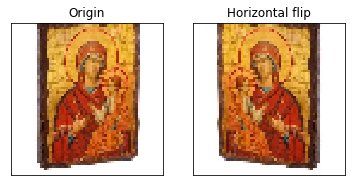

In [76]:
def horizontal_flip(X):
    '''
    Зеркально отразить изображение X.
    Размерность X: (image_h, image_w, channels)
    '''
    # code
    X_flip = X[:,::-1]
    return X_flip

i = 2268
plt.figure(figsize=(6,3))

plt.subplot(1,2,1)
plt.imshow(X_train[i].T)
plt.xticks(()); plt.yticks(()); 
plt.title('Origin')

plt.subplot(1,2,2)
plt.imshow(horizontal_flip(X_train[i].T))
plt.xticks(()); plt.yticks(()); 
plt.title('Horizontal flip');

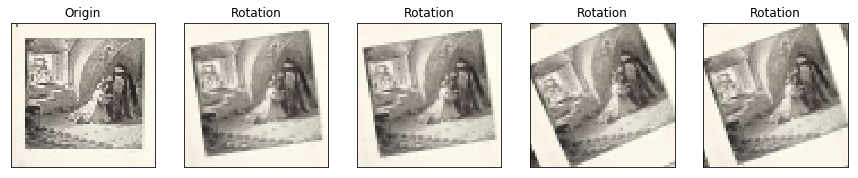

In [84]:
from skimage.transform import rotate

def random_rotation(X, alpha=30):
    '''
    Повернуть изображение X на случайное количество градусов в диапазоне [-alpha, alpha], alpha \in [0, 180].
    Размерность X: (image_h, image_w, channels)
    '''
    # code
    X_rotated = rotate(X, alpha * (np.random.random()*2-1), mode = 'symmetric')
    return X_rotated

i = 40
plt.figure(figsize=(15,3))

plt.subplot(1,5,1)
plt.imshow(X_train[i].T)
plt.xticks(()); plt.yticks(()); 
plt.title('Origin')
for j in range(4):
    plt.subplot(1,5,j+2)
    plt.imshow(random_rotation(X_train[i].T))
    plt.title('Rotation')
    plt.xticks(()); plt.yticks(()); 

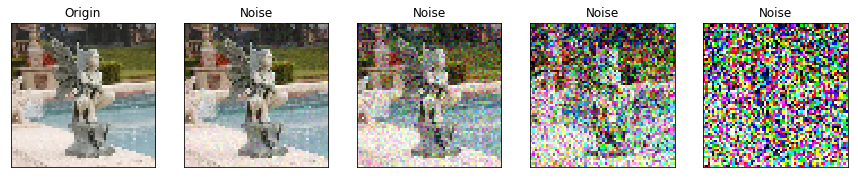

In [85]:
def random_noise(X, std=1.0):
    '''
    Добавить к изображению X случайный гауссовский шум со стандартным отклонением std > 0.
    Размерность X: (image_h, image_w, channels)
    '''
    # code
    X_noise = X + std**0.5 * np.random.randn(*X.shape)
    return np.maximum(0, np.minimum(X_noise, 1))


i = 3130
plt.figure(figsize=(15,3))

plt.subplot(1,5,1)
plt.imshow(X_train[i].T)
plt.xticks(()); plt.yticks(()); 
plt.title('Origin')

for j in range(4):
    plt.subplot(1,5,j+2)
    plt.imshow(random_noise(X_train[i].T, 0.1 ** (-j+3)))
    plt.title('Noise')
    plt.xticks(()); plt.yticks(()); 

In [86]:
X_train_augmented = np.concatenate([
    X_train,
    [horizontal_flip(x) for x in X_train]
])
y_train_augmented = np.concatenate([y_train, y_train])

100%|██████████| 20/20 [00:20<00:00,  1.04s/it]

Max accuracy: 0.7570


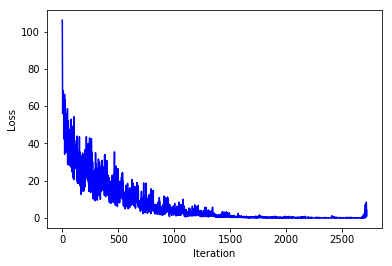

In [87]:
net = ConvNet().cuda()
opt = optim.Adam(net.parameters(), lr)

accuracies = train(net, opt, X_train_augmented, y_train_augmented, X_val, y_val, n_epochs, lr, batch_size)

print('Max accuracy: %.4f' % np.max(accuracies))

In [88]:
results['ConvNet + MaxPool + BN + Aug'] = np.max(accuracies)

In [89]:
pd.DataFrame.sort_values(pd.DataFrame(pd.Series(results), columns=['Accuracy']), 'Accuracy')

,Accuracy
Fully connected,0.668675
ConvNet,0.686747
ConvNet + MaxPool,0.714859
ConvNet + MaxPool + BN,0.751004
ConvNet + MaxPool + BN + Aug,0.757028


## Модель 6: Предобученные сети

In [100]:
model = torchvision.models.alexnet(pretrained=True)

# заморозить градиенты AlexNet
# code
for p in model.parameters():
    p.requires_grad = False

### <center>AlexNet</center>

<img src="https://www.researchgate.net/profile/Sherif_Shehata2/publication/308880040/figure/download/fig3/AS:413548556636165@1475609067864/An-illustration-of-the-architecture-of-AlexNet-deep-convolutional-neural-network.png"/>



In [101]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

In [102]:
# Заменить 1000-классовую классификацию на 5-классовую
# code
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, n_classes)
model.classifier.add_module('Softmax', nn.LogSoftmax(dim=-1))


100%|██████████| 20/20 [00:50<00:00,  2.54s/it]


Max accuracy: 0.8153


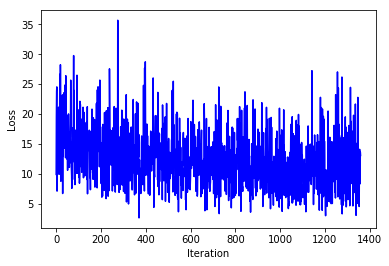

In [104]:
net = model.cuda()
opt = optim.Adam(net.parameters(), lr)

accuracies = train(net, opt, X_train, y_train, X_val, y_val, n_epochs, lr, batch_size)

print('Max accuracy: %.4f' % np.max(accuracies))

In [105]:
results['Finetuned AlexNet'] = np.max(accuracies)

In [106]:
pd.DataFrame.sort_values(pd.DataFrame(pd.Series(results), columns=['Accuracy']), 'Accuracy')

,Accuracy
Fully connected,0.668675
ConvNet,0.686747
ConvNet + MaxPool,0.714859
ConvNet + MaxPool + BN,0.751004
ConvNet + MaxPool + BN + Aug,0.757028
Finetuned AlexNet,0.815261
